In [1]:
from IPython.display import display, Math, Latex
# This is imported for proper rendering of Latex in Notebook.

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

np.random.seed(306)
plt.style.use('seaborn')

# Linear Regression with sklearn API

We will build a linear regression model with `sklearn`. We will be using the following set up:
1. Dataset: California housing
2. Linear Regression API: `LinearRegression`
3. Training: `fit` (normal equation) and `cross_validate` (normal equation with cross validation)
4. Evaluation: `score` (r2 score) and `cross_val_score` with different scoring parameters.

We will study the model diagnosis with `LearningCurve` and learn how to examine the learned model or weight vector.

### Cross Validation

We will use the `ShuffleSplit` cross validation with:
- $10$ folds (`n_splits`) and
- set aside $20\%$ examples as test examples (`test_size`).

In [3]:
from sklearn.model_selection import ShuffleSplit

shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

This creates 10 folds through shuffle split by keeping aside 20% examples as test in each fold.

## **STEP 1:** Load the dataset

The first step is to load the dataset. We will use `California Housing` dataset for demonstration.

In [4]:
from sklearn.datasets import fetch_california_housing

features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

The feature matrix is loaded in the `features` DataFrame and the labels in `labels` Series. Let's examine both.

In [5]:
print(features.shape, labels.shape)

(20640, 8) (20640,)


As a sanity check, make sure that the no. of rows in feature matrix and labels match.

In [6]:
assert(features.shape[0] == labels.shape[0])

## **STEP 2:** Data exploration

In [7]:
features.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [8]:
features.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [10]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000


In [11]:
labels.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

## **STEP 3:** Preprocessing and model building

### 3.1 Train test split

The first step is to split the training data into training and test data. We do not access the test data till the end. All the data exploration and tuning is performed on the training set and by setting aside a small portion of training as dev or validation set.

The following code snippet divides the data into training and test sets.

In [12]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=42)

Let's examine the shaped of training and test sets.

In [13]:
print(train_features.shape, test_features.shape)
print(train_labels.shape, test_labels.shape)

(15480, 8) (5160, 8)
(15480,) (5160,)


## **STEP 4:** Pipeline: Preprocessing + Model

As a first step, we build linear regression models with default parametre setting of Linear Regression APIs.

> We will make use of `Pipeline` API for combining data preprocessing and model building.

We will use `StandardScaler` feture scaling to bring all features on the same scale followed by a `LinearRegression` model.

The `pipeline` object has $2$ components:
1. `StandardScaler` as step 1.
2. `LinearRegression` as step 2.

After constructing the pipeline object, let's train it with training set.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Set up linear regression model.
lin_reg_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('lin_reg', LinearRegression()),
])

# Train linear regression model with Normal Equation
lin_reg_pipeline.fit(train_features,train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('lin_reg', LinearRegression())])

Now, that we have trained the model, let's check the learnt/estimated weight vectors (`intercept_` and `coef_`).

In [15]:
print("Incercept (w_0):\n", lin_reg_pipeline[-1].intercept_)
print("Weight vector (w_1, w_2,...,w_m):\n", lin_reg_pipeline[-1].coef_)

Incercept (w_0):
 2.0703489205426377
Weight vector (w_1, w_2,...,w_m):
 [ 0.85210815  0.12065533 -0.30210555  0.34860575 -0.00164465 -0.04116356
 -0.89314697 -0.86784046]


A couple of things to notice:
- We accesses the `LinearRegression` object as `lin_reg_pipeline[-1]` which is the last step in the pipeline.
- The intercept can be written via `intercept_` member variable and
- The weight vector corresponding to features via `coef_`.

## **STEP 4:** Model Evaluation

### `score`

Let's use `score` method to obtain train and test errors with the following objectives -
> - Estimation of model performance as provided by test error.
> - Comparison of errors for model diagnostic purpose (under/over/right fit).

In [16]:
# evaluate model performance on the training set
training_score = lin_reg_pipeline.score(train_features, train_labels)
print("Model performance on test set: ", training_score)

# evaluate model performance on the test set
test_score = lin_reg_pipeline.score(test_features, test_labels)
print("Model performance on test set: ", test_score)

Model performance on test set:  0.609873031052925
Model performance on test set:  0.591050979549135


The `score` method returns `r2` socre whose best value is $1$. 

The `r2` scores on training and test are comparile but they are not that high. It points to possible underfitting issue in the model.

### Cross Validated Scores (`cross_val_score`)

Since, the `score` was computed on one fold that was selected as a test set, it may not be all that robust. In order to obtain rbust estimate of the performance, we use `cross_val_score` that calculate `score` on different test folds through cross validation.

In [17]:
from sklearn.model_selection import cross_val_score

# We will be using 'shuffle_split_cv' which is a SplitShuffle instance as a cross validation type.
# Reminder: shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# So, we will be checking on 10 folds, so we will get 10 scores as output, one for each fold.
lin_reg_cv_score = cross_val_score(
    lin_reg_pipeline, 
    train_features, 
    train_labels, 
    scoring='neg_mean_squared_error', 
    cv=shuffle_split_cv)

# The scores across the folds:
print("Score of linear regression model on the test set \n (kept aside from the training set itself during `shuffle_split_cv`):\n",lin_reg_cv_score)
# We can take the mean and standard deviations of the score and report it as well
print(f"Mean score of linear regression model on the test set \n (kept aside from the training set itself during `shuffle_split_cv`):\n"
f"{lin_reg_cv_score.mean(): .3f} +/- {lin_reg_cv_score.std(): .3f}")

Score of linear regression model on the test set 
 (kept aside from the training set itself during `shuffle_split_cv`):
 [-0.50009976 -0.52183352 -0.55931218 -0.52110499 -0.56059203 -0.50510767
 -0.52386194 -0.54775518 -0.5007161  -0.54713448]
Mean score of linear regression model on the test set 
 (kept aside from the training set itself during `shuffle_split_cv`):
-0.529 +/-  0.022


Here we got the negative mean squared error as a score. We can convert that to error as follows:

In [18]:
lin_reg_cv_mse = -1*lin_reg_cv_score
print(f"Mean MSE of linear regression model on the test set \n (kept aside from the training set itself during `shuffle_split_cv`):\n"
f"{lin_reg_cv_mse.mean(): .3f} +/- {lin_reg_cv_mse.std(): .3f}")

Mean MSE of linear regression model on the test set 
 (kept aside from the training set itself during `shuffle_split_cv`):
 0.529 +/-  0.022


We can use other `scoring` parameters and obtain cross validated scores based on that parameter. The following choices are made available for `scoring`:
- `explained_variance`
- `max_error`
- `neg_mean_absolute_error`
- `neg_root_mean_squared_error`
- `neg_mean_squared_log_error`
- `neg_median_absolute_error`
- `neg_mean_absolute_percentage_error`
- `r2`

### Better Cross Validation (`cross_validate`)

We just calculated the cross validation scores across $10$ folds using `cross_val_score`.

It however returns only scores for each fold. We may also need to access the models trained in each fold along with some other statistics like the training error for each fold. We go on to use `cross_validate` method for that.

In [19]:
from sklearn.model_selection import cross_validate

lin_reg_cv_results = cross_validate(
    lin_reg_pipeline, 
    train_features, 
    train_labels, 
    cv=shuffle_split_cv, 
    scoring="neg_mean_squared_error", 
    return_train_score=True, 
    return_estimator=True)

The `lin_reg_cv_results` is a dictionary with the following contents:
- trained `estimators`,
- time taken for fitting (`fit_time`) and scoring (`score_time`) the models in cross validation,
- training score (`train_score`) and
- test scores (`test_score`)

Let's print the contents of the dictionary to examine.

In [20]:
lin_reg_cv_results

{'fit_time': array([0.01499128, 0.00761199, 0.00651288, 0.00725079, 0.00716281,
        0.00681615, 0.00582004, 0.00598216, 0.00556517, 0.00567508]),
 'score_time': array([0.00210381, 0.00205588, 0.00142097, 0.00161314, 0.00193501,
        0.00335503, 0.00153089, 0.00159407, 0.00149989, 0.00151396]),
 'estimator': [Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('featu

There are $10$ values in each dictionary key. That is because of $cv = shuffle_split_cv$, which is splitting the training set into $10$ folds.

We compare training and test errors to access generalization performance of the model. However we have training and test scores in the `train_score` and `test_score` keys.
> Multiply these scores by $-1$ and convert them to errors.

In [21]:
train_error = -1 * lin_reg_cv_results['train_score']
test_error = -1 * lin_reg_cv_results['test_score']

print(f"Mean MSE of linear regression model on the training set \n (kept aside from the training set itself during `shuffle_split_cv`):\n"
f"{train_error.mean(): .3f} +/- {train_error.std(): .3f}")

print(f"Mean MSE of linear regression model on the test set \n (kept aside from the training set itself during `shuffle_split_cv`):\n"
f"{test_error.mean(): .3f} +/- {test_error.std(): .3f}")

Mean MSE of linear regression model on the training set 
 (kept aside from the training set itself during `shuffle_split_cv`):
 0.519 +/-  0.006
Mean MSE of linear regression model on the test set 
 (kept aside from the training set itself during `shuffle_split_cv`):
 0.529 +/-  0.022


- The training and test errors are high, which is an indication of underfitting, which we will confirm by plotting the learning curves.

- Test error has higher variability across different flds compared to the train error.

### Effect of training set size on error

Let's understand how training set size or no. of samples affect the error. We can use `learning_curve` API that calculates cross validation scores for different no. of samples as specified in its argument `train_sizes`.

In [22]:
# Helper function for plotting the learning curves

def plot_learning_curve(train_sizes, train_scores, test_scores, fit_times):

    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(-train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(-test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha = 0.1,
        color = 'r',
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha = 0.1,
        color = 'g',
    )

    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='training')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='test')
    plt.xlabel('# of training examples')
    plt.ylabel('MSE')
    plt.legend(loc='best')
    plt.show()


Based on the scores calculated by `learning_curve` API, we plot the error and its standard deviation for different no. of samples.

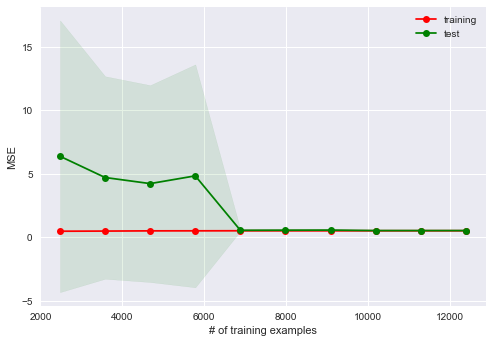

In [23]:
from sklearn.model_selection import learning_curve

(train_sizes, train_scores, test_scores, fit_times, score_times) = learning_curve(
    lin_reg_pipeline,
    train_features,
    train_labels,
    cv=shuffle_split_cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1, # Number of jobs to run in parallel
    return_times=True, # Whether to return fit and score times
    train_sizes=np.linspace(0.2,1.0, 10) # Number of training examples
)

plot_learning_curve(train_sizes, train_scores, test_scores, fit_times)

Observe that
- Both curves have reached a plateu; they are close and fairly high.
- Few instances in the training set means the model can fit them perfectly. But as more instances are added to the training set, it becomes impossible for the model to fit the training data pefectly.
- When the model is trained on very few training instances, it is not able to generalize properly, which is why the validation error is initially quite high. Then as the model learns on more training examples, the training and validation errors reduce slowly.

These learning curves are typical of an underfitting model.

### Model Examination

Let's examine the weight vectors and how much variability exists between them across different cross-validated models.

In [24]:
feature_names = train_features.columns
feature_names

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

For this, we will first construct a DataFrame of weight vectors and then plot them using `box` plot.

<Figure size 1152x432 with 0 Axes>

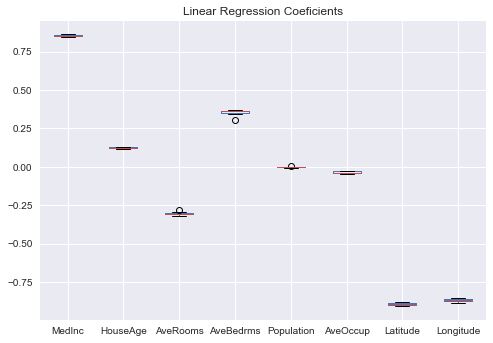

In [25]:
coefs = [est[-1].coef_ for est in lin_reg_cv_results['estimator']]
weights_df = pd.DataFrame(coefs, columns=feature_names)

plt.figure(figsize=(16,6))
weights_df.plot.box()
plt.title("Linear Regression Coeficients")
plt.show()

In [27]:
weights_df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,10.0,0.852153,0.005763,0.843517,0.848871,0.852711,0.854743,0.861659
HouseAge,10.0,0.122770,0.004312,0.117394,0.119895,0.121592,0.125520,0.130560
AveRooms,10.0,-0.304384,0.010998,-0.318971,-0.310778,-0.305795,-0.302980,-0.278426
AveBedrms,10.0,0.353528,0.018044,0.307474,0.349715,0.360139,0.364646,0.367952
Population,10.0,-0.001576,0.003254,-0.005787,-0.002688,-0.002063,-0.000350,0.005297
AveOccup,10.0,-0.037059,0.008582,-0.047584,-0.042486,-0.042325,-0.027562,-0.026331
Latitude,10.0,-0.894011,0.009975,-0.908058,-0.901411,-0.895370,-0.883967,-0.881884
Longitude,10.0,-0.869753,0.009097,-0.884206,-0.876542,-0.869631,-0.862110,-0.857844


There is not much variability in weights learned by different models. It can also be seen by the standard deviation of weights as seen in the `std` column above.

### Selecting best model

Let's select the model with the lowest cross validated test error as the best performing model.

In [29]:
# Let's find out the best model that resulted in the least test error.
best_model_index = np.argmin(test_error)
selected_model = lin_reg_cv_results['estimator'][best_model_index]
print(selected_model)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('lin_reg', LinearRegression())])


Let's examine the `selected_model` coefficients.

In [30]:
print("Incercept (w_0):\n", selected_model[-1].intercept_)
print("Weight vector (w_1, w_2,...,w_m):\n", selected_model[-1].coef_)

# This also works ---
# print("Incercept (w_0):\n", selected_model['lin_reg'].intercept_)

Incercept (w_0):
 2.0779898917958657
Weight vector (w_1, w_2,...,w_m):
 [ 8.44324888e-01  1.18463901e-01 -3.04619574e-01  3.56620503e-01
  1.74458509e-04 -4.23964612e-02 -8.96045642e-01 -8.68906479e-01]


### Model performance

Towards this, let's first obtain the predictions for test points in cross validation.

In [33]:
from sklearn.model_selection import cross_val_predict
cv_predictions = cross_val_predict(
    lin_reg_pipeline,
    train_features,
    train_labels,
)

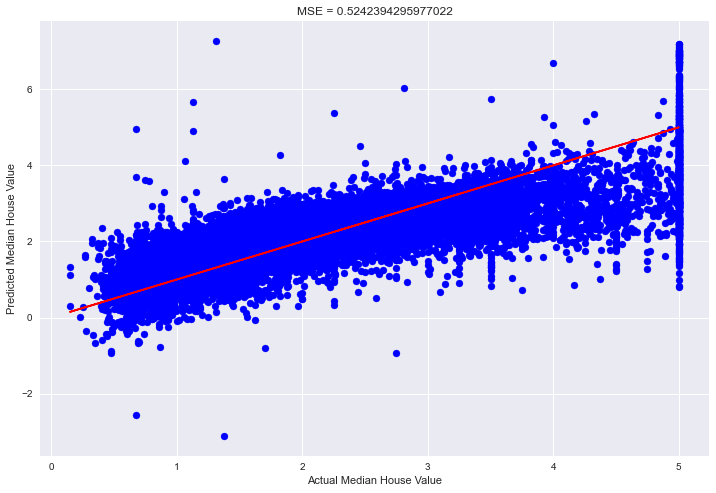

In [36]:
from sklearn.metrics import mean_squared_error
mse_cv = mean_squared_error(train_labels, cv_predictions)

plt.figure(figsize=(12,8))
plt.scatter(train_labels, cv_predictions, color='blue')
plt.plot(train_labels,train_labels, 'r-')
plt.title(f'MSE = {mse_cv}')
plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Median House Value')
plt.show()

**Observations:**
- The model seems to be all over the place in its predictions for examples with label $5$.
- There are some negative predictions. We can fix this by adding a constraint on the weights to be positive.

At this stage, we should perform error analysis and check where the predictions are going wrong. We an revisit feature construction, preprocessing or model stages and make the necessary corrections to obtain better performance.

## **STEP 5:** Predictions

We can use the best performing model from the cross validation for getting predictions on the test set.

In [37]:
test_predictions_cv = selected_model.predict(test_features)
test_predictions_cv[:5]

array([0.73548515, 1.7725621 , 2.70011199, 2.83716602, 2.60743151])

We can also obtain predictions using the initial model that we built without cross validaiton.

In [38]:
test_predictions_without_cv = lin_reg_pipeline.predict(test_features)
test_predictions_without_cv[:5]

array([0.72412832, 1.76677807, 2.71151581, 2.83601179, 2.603755  ])

## **STEP 6:** Report model performance

We report model performance on the test set.

In [39]:
score_cv = selected_model.score(test_features, test_labels)
score_without_cv = lin_reg_pipeline.score(test_features, test_labels)

print("R2 score for the best model obtained via cross validation: ", score_cv)
print("R2 score for model without cross validation: ", score_without_cv)


R2 score for the best model obtained via cross validation:  0.5923577635319088
R2 score for model without cross validation:  0.591050979549135


As we can see the the score for the model without cross-validation is slightly lower than that of with cross-validation.

Alternatively, we can use any other metric of interest and report performance based on that. For example, we can use the `mean_squared_error` as follows:

In [40]:
from sklearn.metrics import mean_squared_error

mse_cv = mean_squared_error(test_labels, test_predictions_cv)
mse_without_cv = mean_squared_error(test_labels, test_predictions_without_cv)

print("MSE for the best model obtained via cross validation: ", mse_cv)
print("MSE for model without cross validation: ", mse_without_cv)

MSE for the best model obtained via cross validation:  0.5393995876218521
MSE for model without cross validation:  0.541128747847069


We can confirm that the cross validation based model has slightly better MSE than the one without.

**To Do:**
- Repeat the modeling steps with `SGDRegressor`.